# Blocking Analysis

In [14]:
import numpy as np
import scipy as sp
import h5py 
import pandas as pd
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy

## Test of dataset

In [15]:
file = f'blocking_info/CanESM2/blocking_info_canesm2_historical_rcp85_1_1980_2100_nh.mat'
matfile = h5py.File(file)
print(matfile.keys())
matfile['UB_info_TM'].shape

<KeysViewHDF5 ['AB_freq_Ac', 'AB_freq_TM', 'AB_info_Ac', 'AB_info_TM', 'UB_freq_Ac', 'UB_freq_TM', 'UB_info_Ac', 'UB_info_TM']>


(4, 71)

In [16]:
file = f'blocking_info/GFDL-CM3/blocking_info_gfdl_cm3_historical_rcp85_1_1980_2100_nh.mat'
matfile = h5py.File(file)
print(matfile.keys())
matfile['UB_info_TM'].shape

<KeysViewHDF5 ['AB_freq_Ac', 'AB_freq_TM', 'AB_info_Ac', 'AB_info_TM', 'UB_freq_Ac', 'UB_freq_TM', 'UB_info_Ac', 'UB_info_TM']>


(4, 114)

In [17]:
file = f'blocking_info/CESM1/blocking_info_cesm1_historical_1_1980_2005_nh.mat'
matfile1 = h5py.File(file)
print(matfile1.keys())
print(matfile1['UB_info_TM'].shape)

file = f'blocking_info/CESM1/blocking_info_cesm1_rcp85_1_2006_2024_nh.mat'
matfile2 = h5py.File(file)
print(matfile2.keys())
print(matfile2['UB_info_TM'].shape)

file = f'blocking_info/CESM1/blocking_info_cesm1_rcp85_1_2065_2100_nh.mat'
matfile3 = h5py.File(file)
print(matfile3.keys())
print(matfile3['UB_info_TM'].shape)

<KeysViewHDF5 ['AB_freq_Ac', 'AB_freq_TM', 'AB_info_Ac', 'AB_info_TM', 'UB_freq_Ac', 'UB_freq_TM', 'UB_info_Ac', 'UB_info_TM']>
(4, 26)
<KeysViewHDF5 ['AB_freq_Ac', 'AB_freq_TM', 'AB_info_Ac', 'AB_info_TM', 'UB_freq_Ac', 'UB_freq_TM', 'UB_info_Ac', 'UB_info_TM']>
(4, 18)
<KeysViewHDF5 ['AB_freq_Ac', 'AB_freq_TM', 'AB_info_Ac', 'AB_info_TM', 'UB_freq_Ac', 'UB_freq_TM', 'UB_info_Ac', 'UB_info_TM']>
(4, 38)


## Read dataset

In [18]:
class Block():
    def __init__(self, ensemble_size, ys, ye):
        self.ensemble_size = ensemble_size
        self.num_year = ye - ys + 1
        self.year = np.linspace(ys, ye, self.num_year, dtype=np.int32)
        self.reset()

    def reset(self):
        self.num_event = np.ones((self.ensemble_size, self.num_year))*np.nan
        self.duration = np.ones((self.ensemble_size, self.num_year))*np.nan
        self.intensity = np.ones((self.ensemble_size, self.num_year))*np.nan


B = Block(50, 1980, 2100)
print(f"ys:{B.year[0]}, ye:{B.year[-1]}")


ys:1980, ye:2100


In [19]:
class Model():
    def __init__(self, model_name, ensemble_size, ys, ye):
        self.model_name = model_name
        self.B = Block(ensemble_size, ys, ye)

    def read_member(self, member, var_name):
        file = f'blocking_info/{self.model_name}/blocking_info_canesm2_historical_rcp85_{member}_1980_2100_nh.mat'
        matfile = h5py.File(file)
        #print(matfile.keys())
        return matfile[var_name]

    def read_B_info(self, var_name):
        self.B.reset()
        for member in range(1, self.B.ensemble_size+1):
            B_info = self.read_member(member, var_name)
            for i, year in enumerate(self.B.year):
                index = (B_info[0,:].astype(np.int32) == year)       # find the index for year in B_info
                num_event = len(B_info[0,:][index])                  # number of events
                self.B.num_event[member-1, i] = num_event
                if num_event > 0:
                    duration = np.mean(B_info[2,:][index] -B_info[1,:][index] +1)
                    self.B.duration[member-1, i] = duration    # mean duration
                    self.B.intensity[member-1, i] = np.mean((B_info[2,:][index] -B_info[1,:][index] +1)
                                                            *B_info[3,:][index])/duration    # mean intensity
        
        for i in range(len(self.B.year)):
            if np.sum(self.B.num_event[:, i]) < 1:     # no block found 
                self.B.num_event[:, i] = np.nan

        return self.B
        
CanESM2 = Model(model_name='CanESM2', ensemble_size=50, ys=1980, ye=2100)
UB_TM_1 = copy.deepcopy(CanESM2.read_B_info('UB_info_TM'))
UB_Ac_1 = copy.deepcopy(CanESM2.read_B_info('UB_info_Ac'))
AB_TM_1 = copy.deepcopy(CanESM2.read_B_info('AB_info_TM'))
AB_Ac_1 = copy.deepcopy(CanESM2.read_B_info('AB_info_Ac'))

In [20]:
class GFDL(Model):
    def __init__(self, model_name, ensemble_size, ys, ye):
        super().__init__(model_name, ensemble_size, ys, ye)

    def read_member(self, member, var_name):
        file = f'blocking_info/{self.model_name}/blocking_info_gfdl_cm3_historical_rcp85_{member}_1980_2100_nh.mat'
        matfile = h5py.File(file)
        #print(matfile.keys())
        return matfile[var_name]

GFDL = GFDL(model_name='GFDL-CM3', ensemble_size=20, ys=1980, ye=2100)
UB_TM_2 = copy.deepcopy(GFDL.read_B_info('UB_info_TM'))
UB_Ac_2 = copy.deepcopy(GFDL.read_B_info('UB_info_Ac'))
AB_TM_2 = copy.deepcopy(GFDL.read_B_info('AB_info_TM'))
AB_Ac_2 = copy.deepcopy(GFDL.read_B_info('AB_info_Ac'))

In [21]:
class CESM1(Model):
    def __init__(self, model_name, ensemble_size, ys, ye):
        super().__init__(model_name, ensemble_size, ys, ye)

    def read_member(self, member, var_name):
        file = f'blocking_info/{self.model_name}/blocking_info_cesm1_historical_{member}_1980_2005_nh.mat'
        matfile1 = h5py.File(file)
        file = f'blocking_info/{self.model_name}/blocking_info_cesm1_rcp85_{member}_2006_2024_nh.mat'
        matfile2 = h5py.File(file)
        file = f'blocking_info/{self.model_name}/blocking_info_cesm1_rcp85_{member}_2065_2100_nh.mat'
        matfile3 = h5py.File(file)

        return np.hstack((matfile1[var_name], matfile2[var_name], matfile3[var_name]))

CESM1 = CESM1(model_name='CESM1', ensemble_size=40, ys=1980, ye=2100)
UB_TM_3 = copy.deepcopy(CESM1.read_B_info('UB_info_TM'))
UB_Ac_3 = copy.deepcopy(CESM1.read_B_info('UB_info_Ac'))
AB_TM_3 = copy.deepcopy(CESM1.read_B_info('AB_info_TM'))
AB_Ac_3 = copy.deepcopy(CESM1.read_B_info('AB_info_Ac'))

In [22]:
class CESM2(Model):
    def __init__(self, model_name, ensemble_size, ys, ye):
        super().__init__(model_name, ensemble_size, ys, ye)

    def read_member(self, member, var_name):
        m1 = (member-1) % 10 +1
        m2 = np.floor((member-1)/10).astype(int)
        m2_str =['1001', '1231', '1251', '1281', '1301']
        yy_str =['1980_1989', '1990_1999', '2000_2009', \
                 '2010_2014', '2015_2024', '2065_2075', \
                 '2075_2085', '2085_2095', '2095_2100' ]
        matfile_var = np.empty((4, 0))
        for y_str in yy_str:
            file = f'blocking_info/{self.model_name}/blocking_info_cmip6_{m2_str[m2]}_{m1}_{y_str}_.mat'
            matfile = h5py.File(file)
            if matfile[var_name].shape[0] == 4:
                matfile_var = np.hstack((matfile_var, matfile[var_name]))
            else:
#                print(f'blocking_info_cmip6_{m2_str[m2]}_{m1}_{y_str}.mat({member}): {matfile[var_name].shape}')
                pass
                   
        return matfile_var

CESM2 = CESM2(model_name='CESM2', ensemble_size=40, ys=1980, ye=2100)
UB_TM_4 = copy.deepcopy(CESM2.read_B_info('UB_info_TM'))
UB_Ac_4 = copy.deepcopy(CESM2.read_B_info('UB_info_Ac'))
AB_TM_4 = copy.deepcopy(CESM2.read_B_info('AB_info_TM'))
AB_Ac_4 = copy.deepcopy(CESM2.read_B_info('AB_info_Ac'))

## Plotting the average number of blocks per winter

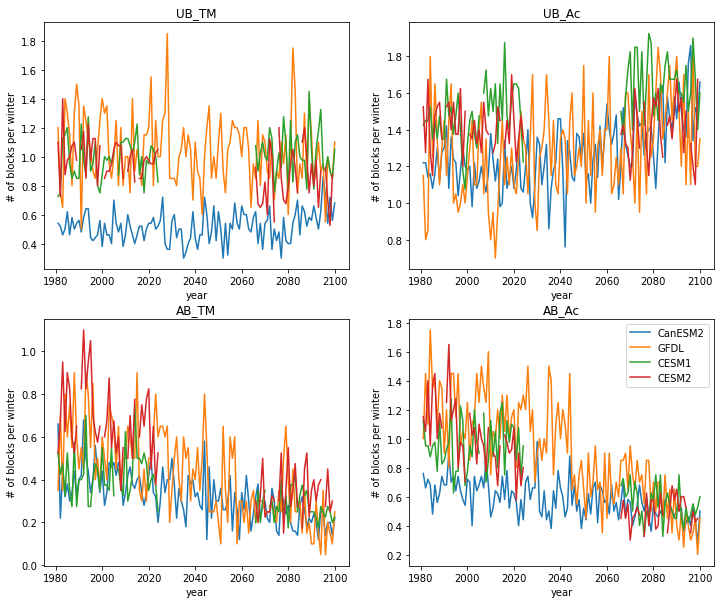

In [23]:
model_name = ['CanESM2', 'GFDL', 'CESM1', 'CESM2']
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(2,2,1)
for i, UB_TM in enumerate([UB_TM_1, UB_TM_2, UB_TM_3, UB_TM_4]):
    # skipping 1980 due to zero blocks
    plt.plot(UB_TM.year[1:], np.mean(UB_TM.num_event[:, 1:], axis=0))  # use regular mean
    # plt.plot(UB_Ac.year[1:], np.mean(UB_Ac.num_event[:, 1:], axis=0), label='UB_Ac')
    plt.xlabel('year')
    plt.ylabel('# of blocks per winter')
    plt.title('UB_TM')
    # plt.legend()

ax = fig.add_subplot(2,2,2)
for i, UB_Ac in enumerate([UB_Ac_1, UB_Ac_2, UB_Ac_3, UB_Ac_4]):
    # skipping 1980 due to zero blocks
    plt.plot(UB_Ac.year[1:], np.mean(UB_Ac.num_event[:, 1:], axis=0))  # use regular mean
    # plt.plot(UB_Ac.year[1:], np.mean(UB_Ac.num_event[:, 1:], axis=0), label='UB_Ac')
    plt.xlabel('year')
    plt.ylabel('# of blocks per winter')
    plt.title('UB_Ac')
    # plt.legend()

ax = fig.add_subplot(2,2,3)
for i, AB_TM in enumerate([AB_TM_1, AB_TM_2, AB_TM_3, AB_TM_4]):
    # skipping 1980 due to zero blocks
    plt.plot(AB_TM.year[1:], np.mean(AB_TM.num_event[:, 1:], axis=0))  # use regular mean
    # plt.plot(AB_TM.year[1:], np.mean(AB_TM.num_event[:, 1:], axis=0), label='AB_TM')
    plt.xlabel('year')
    plt.ylabel('# of blocks per winter')
    plt.title('AB_TM')
    # plt.legend()

ax = fig.add_subplot(2,2,4)
for i, AB_Ac in enumerate([AB_Ac_1, AB_Ac_2, AB_Ac_3, AB_Ac_4]):
    # skipping 1980 due to zero blocks
    plt.plot(AB_Ac.year[1:], np.mean(AB_Ac.num_event[:, 1:], axis=0), label=model_name[i])  # use regular mean
    # plt.plot(AB_Ac.year[1:], np.mean(AB_Ac.num_event[:, 1:], axis=0), label='AB_Ac')
    plt.xlabel('year')
    plt.ylabel('# of blocks per winter')
    plt.title('AB_Ac')
    plt.legend()

## Select the Model to display

In [27]:
UB_TM = UB_TM_4
UB_Ac = UB_Ac_4
AB_TM = AB_TM_4
AB_Ac = AB_Ac_4

## Plotting the average duration per block and duration at different percentiles

/Users/gchenpu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/gchenpu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/gchenpu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/gchenpu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


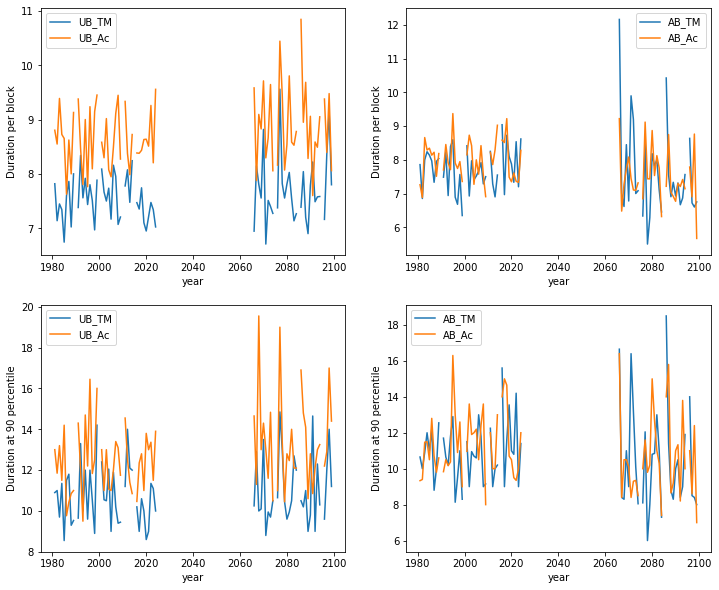

In [28]:
fig = plt.figure(figsize=(12,10))

# mean
ax = fig.add_subplot(2,2,1)
# skipping 1980 due to zero blocks
plt.plot(UB_TM.year[1:], np.nansum(UB_TM.duration[:, 1:]*UB_TM.num_event[:, 1:], axis=0) \
                         /np.sum(UB_TM.num_event[:, 1:], axis=0), label='UB_TM')  # use event-based nansum
plt.plot(UB_Ac.year[1:], np.nansum(UB_Ac.duration[:, 1:]*UB_Ac.num_event[:, 1:], axis=0) \
                         /np.sum(UB_Ac.num_event[:, 1:], axis=0), label='UB_Ac')  # use event-based nansum
plt.xlabel('year')
plt.ylabel('Duration per block')
plt.legend()

ax = fig.add_subplot(2,2,2)
# skipping 1980 due to zero blocks
plt.plot(AB_TM.year[1:], np.nansum(AB_TM.duration[:, 1:]*AB_TM.num_event[:, 1:], axis=0) \
                         /np.sum(AB_TM.num_event[:, 1:], axis=0), label='AB_TM')  # use event-based nansum
plt.plot(AB_Ac.year[1:], np.nansum(AB_Ac.duration[:, 1:]*AB_Ac.num_event[:, 1:], axis=0) \
                         /np.sum(AB_Ac.num_event[:, 1:], axis=0), label='AB_Ac')  # use event-based nansum
plt.xlabel('year')
plt.ylabel('Duration per block')
plt.legend()

# percentile
pctl_value=90

ax = fig.add_subplot(2,2,3)
# skipping 1980 due to zero blocks
plt.plot(UB_TM.year[1:], np.nanpercentile(UB_TM.duration[:, 1:], pctl_value, axis=0), \
                          label='UB_TM') 
plt.plot(UB_Ac.year[1:], np.nanpercentile(UB_Ac.duration[:, 1:], pctl_value, axis=0), \
                          label='UB_Ac')
plt.xlabel('year')
plt.ylabel(f'Duration at {pctl_value} percentile')
plt.legend()

ax = fig.add_subplot(2,2,4)
# skipping 1980 due to zero blocks
plt.plot(AB_TM.year[1:], np.nanpercentile(AB_TM.duration[:, 1:], pctl_value, axis=0), \
                          label='AB_TM') 
plt.plot(AB_Ac.year[1:], np.nanpercentile(AB_Ac.duration[:, 1:], pctl_value, axis=0), \
                          label='AB_Ac')
plt.xlabel('year')
plt.ylabel(f'Duration at {pctl_value} percentile')
plt.legend()


## Plotting average intensity per block and intensity at different percentiles
### Ac results are scaled by a factor 1/4 to compare with TM

/var/folders/7k/vdzxdzv55wl_hy5vrskg592h0000gq/T/ipykernel_32739/2967495644.py:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(UB_TM.year[1:], np.nansum(UB_TM.intensity[:, 1:]*UB_TM.duration[:, 1:]*UB_TM.num_event[:, 1:], axis=0) \
/var/folders/7k/vdzxdzv55wl_hy5vrskg592h0000gq/T/ipykernel_32739/2967495644.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(UB_Ac.year[1:], np.nansum(UB_Ac.intensity[:, 1:]*UB_Ac.duration[:, 1:]*UB_Ac.num_event[:, 1:], axis=0) \
/var/folders/7k/vdzxdzv55wl_hy5vrskg592h0000gq/T/ipykernel_32739/2967495644.py:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AB_TM.year[1:], np.nansum(AB_TM.intensity[:, 1:]*AB_TM.duration[:, 1:]*AB_TM.num_event[:, 1:], axis=0) \
/var/folders/7k/vdzxdzv55wl_hy5vrskg592h0000gq/T/ipykernel_32739/2967495644.py:16: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AB_Ac.year[1:], np.nansum(AB_Ac.intensity[:, 1:]*AB_Ac.duration[:, 1:]*AB_Ac.num_ev

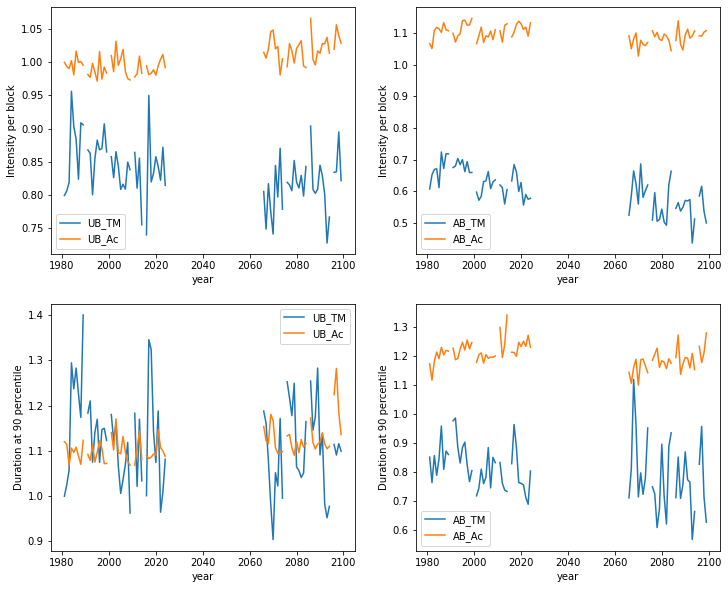

In [29]:

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(2,2,1)
# skipping 1980 due to zero blocks
plt.plot(UB_TM.year[1:], np.nansum(UB_TM.intensity[:, 1:]*UB_TM.duration[:, 1:]*UB_TM.num_event[:, 1:], axis=0) \
                         /np.nansum(UB_TM.duration[:, 1:]*UB_TM.num_event[:, 1:], axis=0), label='UB_TM')  # use event-based nansum
plt.plot(UB_Ac.year[1:], np.nansum(UB_Ac.intensity[:, 1:]*UB_Ac.duration[:, 1:]*UB_Ac.num_event[:, 1:], axis=0) \
                         /np.nansum(UB_Ac.duration[:, 1:]*UB_Ac.num_event[:, 1:], axis=0)/4, label='UB_Ac')  # use event-based nansum; scaled by a factor of 4
plt.xlabel('year')
plt.ylabel('Intensity per block')
plt.legend()

ax = fig.add_subplot(2,2,2)
# skipping 1980 due to zero blocks
plt.plot(AB_TM.year[1:], np.nansum(AB_TM.intensity[:, 1:]*AB_TM.duration[:, 1:]*AB_TM.num_event[:, 1:], axis=0) \
                         /np.nansum(AB_TM.duration[:, 1:]*AB_TM.num_event[:, 1:], axis=0), label='AB_TM')  # use event-based nansum
plt.plot(AB_Ac.year[1:], np.nansum(AB_Ac.intensity[:, 1:]*AB_Ac.duration[:, 1:]*AB_Ac.num_event[:, 1:], axis=0) \
                         /np.nansum(AB_Ac.duration[:, 1:]*AB_Ac.num_event[:, 1:], axis=0)/4, label='AB_Ac')  # use event-based nansum; scaled by a factor of 4
plt.xlabel('year')
plt.ylabel('Intensity per block')
plt.legend()

# percentile
pctl_value=90

ax = fig.add_subplot(2,2,3)
# skipping 1980 due to zero blocks
plt.plot(UB_TM.year[1:], np.nanpercentile(UB_TM.intensity[:, 1:], pctl_value, axis=0), \
                          label='UB_TM') 
plt.plot(UB_Ac.year[1:], np.nanpercentile(UB_Ac.intensity[:, 1:], pctl_value, axis=0)/4, \
                          label='UB_Ac')
plt.xlabel('year')
plt.ylabel(f'Duration at {pctl_value} percentile')
plt.legend()

ax = fig.add_subplot(2,2,4)
# skipping 1980 due to zero blocks
plt.plot(AB_TM.year[1:], np.nanpercentile(AB_TM.intensity[:, 1:], pctl_value, axis=0), \
                          label='AB_TM') 
plt.plot(AB_Ac.year[1:], np.nanpercentile(AB_Ac.intensity[:, 1:], pctl_value, axis=0)/4, \
                          label='AB_Ac')
plt.xlabel('year')
plt.ylabel(f'Duration at {pctl_value} percentile')
plt.legend()